In [1]:
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_auc_score, PrecisionRecallDisplay
import numpy as np
from core import bw_color_palette
from sklearn.calibration import calibration_curve
from tqdm import tqdm
from joblib import Parallel, delayed
import random

In [2]:
plt.rcParams['font.size'] = 7
plt.rcParams['svg.fonttype'] = 'none'

In [3]:
def assign_row_cateogry(row):
    if not pd.isna(row['go_process']):
        if ' | ' in row['go_process']:
            random.seed(7)
            category = random.sample(row['go_process'].split(' | '), 1)[0]
        else:
            category = row['go_process']
    elif not pd.isna(row['cog_name']):
        category = row['cog_name']
    elif not pd.isna(row['gene_name']):
        category = row['gene_name']
    else:
        category = 'unassigned'
    return category

In [4]:
train_homolog_df = pd.read_csv('../data/interim/test_predictions_train_search.csv')
cosine_similarity_df = pd.read_parquet('../data/interim/test_predictions_cosine_similarity.pq')
gba_df = pd.read_csv('../data/interim/test_predictions_cluster_defense_neighbor.csv')

In [5]:
all_gene_component_df = pd.read_csv('../data/interim/defense_finder_gene_split_df.csv')

## Calculate predictions for Beaker models

In [6]:
beaker_only_neighbors = joblib.load('../models/beaker_v3_context.pkl')
beaker_2_neighbors = joblib.load('../models/beaker_v3.pkl')
beaker_1_neighbors = joblib.load('../models/beaker_v3_1_neighbor.pkl')
beaker_0_neighbors = joblib.load('../models/beaker_v3_center.pkl')
beaker_0_neighbors_esm = joblib.load('../models/beaker_v3_0_neighbor_ESM2.pkl')
ridge_cv = joblib.load('../models/center_esm_lasso.pkl')
fe_model = joblib.load('../models/fe_model.pkl')

In [7]:
base_test_X = pd.read_parquet('../data/interim/test_X.pq')
fe_test_X = pd.read_parquet('../data/interim/test_X_fe.pq')
base_test_y = pd.read_parquet('../data/interim/test_y_indexed.pq')
test_annotations = pd.read_parquet('../data/interim/test_seq_names_processes.pq')


In [8]:
(base_test_y.index == base_test_X.index).all()

True

In [9]:
(base_test_y.index == fe_test_X.index).all()

True

In [10]:
prediction_df = base_test_y.copy()

In [11]:
prediction_df['2_neighbors'] = beaker_2_neighbors.predict_proba(base_test_X)[:,1]

In [12]:
one_neighbor_test_X = base_test_X.loc[:,
                                              ~base_test_X.columns.str.contains('_2$|_1:2$') & 
                                              ~base_test_X.columns.str.contains('_-2$|_-2:-1$')]
prediction_df['1_neighbor'] = beaker_1_neighbors.predict_proba(one_neighbor_test_X)[:,1]

In [13]:
no_neighbor_test_X = base_test_X.loc[:, base_test_X.columns.str.endswith('_0')]
prediction_df['0_neighbors'] = beaker_0_neighbors.predict_proba(no_neighbor_test_X)[:,1]

In [14]:
no_neighbor_esm_test_X = base_test_X.loc[:, base_test_X.columns.str.contains('ft[0-9]+_0')]
prediction_df['ridge'] = ridge_cv.predict_proba(no_neighbor_esm_test_X)[:, 1]

In [15]:
prediction_df['0_neighbors_esm'] = beaker_0_neighbors_esm.predict_proba(no_neighbor_esm_test_X)[:, 1]

In [16]:
only_neighbor_test_X = base_test_X.loc[:,
                                      ~base_test_X.columns.str.contains('_0$|_0:1$|_-1:0$', 
                                                             regex=True)]
prediction_df['only_neighbors'] = beaker_only_neighbors.predict_proba(only_neighbor_test_X)[:,1]

In [17]:
prediction_df['engineered'] = fe_model.predict_proba(fe_test_X)[:, 1]

In [18]:
prediction_df = ( prediction_df.merge(train_homolog_df.set_index('seq_id'), 
                                     left_index=True, right_index=True)
                .merge(cosine_similarity_df, left_index=True, 
                       right_index=True)
                 .merge(gba_df.set_index('seq_id'), 
                        left_index=True, right_index=True))

In [19]:
test_gene_component_df = all_gene_component_df[all_gene_component_df['split'] == 'test'].reset_index(drop=True)
test_gene_component_df['component'].nunique()

42

In [20]:
merged_prediction_df = (prediction_df.merge(test_annotations, how='inner',
                              left_index=True, right_on='seq_id'))
merged_prediction_df = (merged_prediction_df.merge(test_gene_component_df
                                                   .rename(columns={'name': 'gene_name'}), 
                                                   how='left', on='gene_name'))
pos_component_weight = 1/merged_prediction_df['component'].value_counts()
pos_component_weight = (pos_component_weight/
                        pos_component_weight.sum() * 
                        merged_prediction_df['defense'].sum()).reset_index(name='pos_weight')
merged_prediction_df = merged_prediction_df.merge(pos_component_weight, how='left', 
                                                  on='component')
neg_data = merged_prediction_df[~merged_prediction_df['defense']].copy()

neg_data['unique_category'] = [assign_row_cateogry(row) for _, row in 
                                                 tqdm(neg_data.iterrows(), 
                                                      position=0, total=len(neg_data))]
neg_component_weight = 1/neg_data['unique_category'].value_counts()
neg_component_weight = (neg_component_weight/
                        neg_component_weight.sum() *
                        len(neg_data)).reset_index(name='neg_weight')
merged_prediction_df = (merged_prediction_df.merge(neg_data[['protein_context_id', 'unique_category']], 
                                                   how='left', on='protein_context_id')
                        .merge(neg_component_weight, how='left', on='unique_category'))
merged_prediction_df['weight'] = (merged_prediction_df['pos_weight'].fillna(0) + 
                                  merged_prediction_df['neg_weight'].fillna(0))

100%|██████████| 166256/166256 [00:08<00:00, 18990.59it/s]


In [21]:
model_name_map = {'2_neighbors': 'Defense Predictor', 
                  '1_neighbor': 'One neighbor model', 
                  '0_neighbors': 'No neighbor model', 
                  'only_neighbors': 'Only neighbor model', 
                  'ridge': 'No neighbor model\n(ESM2 only + Ridge)',
                  '0_neighbors_esm': 'No neighbor model\nESM2 features only',
                  'engineered': 'Engineered features',
                  'train_search_score': 'HMM search', 
                  'cosine_similarity': 'ESM2 cosine similarity', 
                  'defense_frac_n_log_p': 'Guilt by association'}

In [22]:
negative_components = merged_prediction_df[['unique_category']].drop_duplicates().dropna()
positive_components = merged_prediction_df[['component_name']].drop_duplicates().dropna()
print('# Positive Components:', len(positive_components))
print('# Negative Components:', len(negative_components))

# Positive Components: 40
# Negative Components: 972


In [23]:
stat_list = list()
n_boot = 200
for i in tqdm(range(n_boot)):
    resampled_pos_components = positive_components.sample(frac=1, random_state=i, replace=True)
    resampled_pos_predictions = (merged_prediction_df.merge(resampled_pos_components, how='inner', 
                                                            on='component_name'))
    resampled_neg_components = negative_components.sample(frac=1, random_state=i, replace=True)
    resampled_neg_predictions = (merged_prediction_df.merge(resampled_neg_components, how='inner', 
                                                            on='unique_category'))
    resampled_predictions = pd.concat([resampled_pos_predictions, resampled_neg_predictions], axis=0)
    for model in model_name_map.keys():
        ap = average_precision_score(y_true=resampled_predictions['defense'],
                                     y_score=resampled_predictions[model], 
                                     sample_weight=resampled_predictions['weight'])
        stat_list.append({'model': model, 
                          'ap': ap, 
                          'i': i})
stat_df = pd.DataFrame(stat_list)

100%|██████████| 200/200 [02:38<00:00,  1.26it/s]


In [24]:
agg_stat_df = (stat_df.groupby('model')
               .agg(mean_ap=('ap', 'mean'), 
                    std_ap=('ap', 'std'))
               .reset_index())


In [25]:
observed_stat_list = list()
for model in model_name_map.keys():
    ap = average_precision_score(y_true=merged_prediction_df['defense'],
                                 y_score=merged_prediction_df[model], 
                                 sample_weight=merged_prediction_df['weight'])
    observed_stat_list.append({'model': model, 
                               'ap': ap, 
                               'i': i})
observed_stat_df = pd.DataFrame(observed_stat_list)      

In [26]:
merged_stat_df = (observed_stat_df.merge(agg_stat_df, how='inner', on='model'))
merged_stat_df['remapped_name'] = merged_stat_df['model'].replace(model_name_map)
merged_stat_df['display_name'] = (merged_stat_df['remapped_name'] + ' (AP = ' + 
                                  merged_stat_df['ap'].round(2).astype(str) + ' ± ' + 
                                  merged_stat_df['std_ap'].round(3).astype(str) + ')')

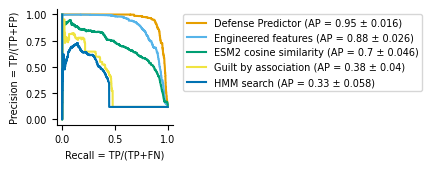

In [27]:
_, ax = plt.subplots(figsize=(1.5, 1.5))
for model, c in zip(['2_neighbors', 'engineered', 'cosine_similarity', 'defense_frac_n_log_p', 'train_search_score'], bw_color_palette):
    name = merged_stat_df.loc[merged_stat_df['model'] == model, 'display_name'].item()
    display = PrecisionRecallDisplay.from_predictions(y_true=merged_prediction_df['defense'],
                                                      y_pred=merged_prediction_df[model], 
                                                      ax=ax, color=c, name=name, 
                                                      sample_weight=merged_prediction_df['weight'])
handles, labels = ax.get_legend_handles_labels()
new_labels = [label[:-12] for label in labels]
ax.legend(handles, new_labels, bbox_to_anchor=(1.04, 1), loc="upper left")
plt.xlabel('Recall = TP/(TP+FN)')
plt.ylabel('Precision = TP/(TP+FP)')
sns.despine()
plt.savefig('../figures/beaker_baselines_pr_cluster_weight.svg', bbox_inches='tight', dpi=300)

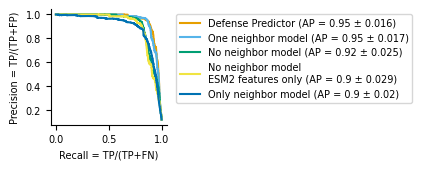

In [28]:
_, ax = plt.subplots(figsize=(1.5, 1.5))
for model, c in zip(['2_neighbors', '1_neighbor', '0_neighbors', 
                     '0_neighbors_esm', 'only_neighbors'], bw_color_palette):
    name = merged_stat_df.loc[merged_stat_df['model'] == model, 'display_name'].item()
    display = PrecisionRecallDisplay.from_predictions(y_true=merged_prediction_df['defense'],
                                                      y_pred=merged_prediction_df[model], 
                                                      ax=ax, color=c, name=name, 
                                                      sample_weight=merged_prediction_df['weight'])
handles, labels = ax.get_legend_handles_labels()
new_labels = [label[:-12] for label in labels]
ax.legend(handles, new_labels, bbox_to_anchor=(1.04, 1), loc="upper left")
plt.xlabel('Recall = TP/(TP+FN)')
plt.ylabel('Precision = TP/(TP+FP)')
sns.despine()
plt.savefig('../figures/beaker_abalations_pr_cluster_weight.svg', bbox_inches='tight', dpi=300)

In [29]:
precision, recall, thresholds = precision_recall_curve(y_true=merged_prediction_df['defense'], 
                                                       probas_pred=merged_prediction_df['2_neighbors'], 
                                                       sample_weight=merged_prediction_df['weight'])
beaker_pr_df = pd.DataFrame({'precision': precision[:-1], 
                             'recall': recall[:-1], 
                             '2_neighbors': thresholds})
pr_merged_prediction_df = merged_prediction_df.merge(beaker_pr_df, how='inner', on='2_neighbors')
pr_merged_prediction_df['2_neighbors_log_odds'] = np.log(pr_merged_prediction_df['2_neighbors']/(1-pr_merged_prediction_df['2_neighbors']))
gene_ap = (pr_merged_prediction_df.groupby('component_name')
           .agg(AP=('precision', 'mean'), 
                average_log_odds = ('2_neighbors_log_odds', 'mean'),
                std_log_odds = ('2_neighbors_log_odds', 'std'),
                n=('seq_id', 'count'))
           .reset_index()
           .sort_values('average_log_odds', ascending=False))
gene_ap['name'] = gene_ap['component_name'].str.split('__', expand=True)[1] + ' (n=' + gene_ap['n'].astype(str) + ')'
gene_ap['name'] = pd.Categorical(gene_ap['name'], categories=gene_ap['name'])

In [32]:
pr_merged_prediction_df.query('precision > 0.75').recall.max()

0.9327887929617669

In [66]:
(gene_ap['average_log_odds'] > 0).sum()

30

In [67]:
len(gene_ap)

40

In [58]:
def custom_barplot(data, x, y, err=None, color='grey', **kwargs):
    """
    Plots a barplot with error bars using matplotlib.

    Parameters:
    - data: DataFrame containing the data.
    - x: str, the name of the column in data.
    - y: str, the name of the column in data.
    - err: str, optional, the name of the column in data representing the error range.
    - color: str, optional, color of the bars (default is 'blue').
    - **kwargs: Additional keyword arguments passed to the plt.bar function.

    Returns:
    - None
    """
    # Determine which is the numeric column
    if pd.api.types.is_numeric_dtype(data[x]):
        numeric_col = x
        categorical_col = y
    elif pd.api.types.is_numeric_dtype(data[y]):
        numeric_col = y
        categorical_col = x
    else:
        raise ValueError("One of x or y must be numeric")
    # Extracting the values from the dataframe
    x_values = data[categorical_col]
    y_values = data[numeric_col]
    # If error bars are provided
    if err is not None:
        err_values = data[err]
    else:
        err_values = np.zeros_like(y_values)
    # Creating the barplot, switching axes if necessary
    if numeric_col == y:
        plt.bar(x_values, y_values, yerr=err_values, color=color, **kwargs)
        plt.xlabel(categorical_col)
        plt.ylabel(numeric_col)
        plt.margins(x=0)
    else:
        plt.barh(x_values, y_values, xerr=err_values, color=color, **kwargs)
        plt.ylabel(categorical_col)
        plt.xlabel(numeric_col)
        plt.margins(y=0)

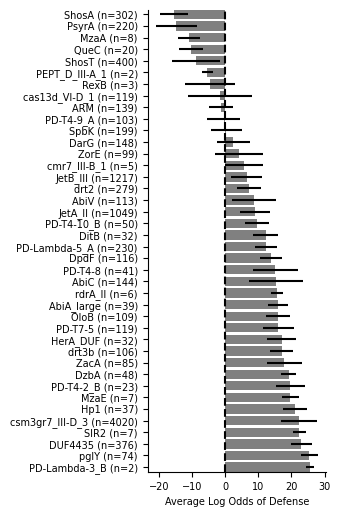

In [59]:
plt.subplots(figsize=(2.3, 6))
custom_barplot(data=gene_ap, y='name', x='average_log_odds', err='std_log_odds', color='grey')
plt.ylabel('')
plt.xlabel('Average Log Odds of Defense')
plt.axvline(x=0, color='black', linestyle='dashed')
sns.despine()
plt.savefig('../figures/gene_component_average_logodds.svg', dpi=300, bbox_inches='tight')

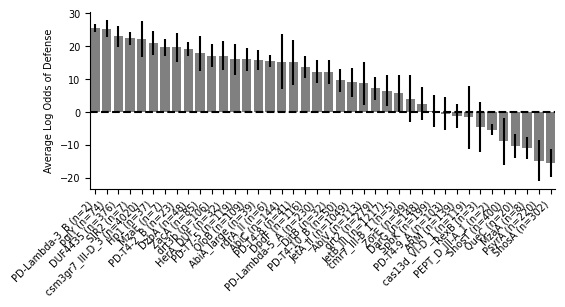

In [64]:
plt.subplots(figsize=(6, 2.3))
custom_barplot(data=gene_ap, x='name', y='average_log_odds', err='std_log_odds', color='grey')
plt.xlabel('')
plt.ylabel('Average Log Odds of Defense')
plt.axhline(y=0, color='black', linestyle='dashed')
sns.despine()
plt.xticks(rotation=45, ha='right')
plt.savefig('../figures/gene_component_average_logodds_T.png', dpi=300, bbox_inches='tight')

In [59]:
pr_merged_prediction_df

,defense,2_neighbors,1_neighbor,0_neighbors,ridge,0_neighbors_esm,only_neighbors,engineered,train_search_score,cosine_similarity,defense_frac_n_log_p,seq_id,protein_id,protein_context_id,gene_name,name,go_process,cog_name,component,component_name,split,pos_weight,unique_category,neg_weight,weight,precision,recall
0,False,1.568592e-09,6.893721e-09,1.671470e-08,0.000392,1.714507e-09,0.004142,4.271528e-06,27.5,0.938228,-0.000000,0000131212b640442569537f5a84e127f7b807991f612d...,WP_082687150.1,WP_082687150.1|NZ_LN831302.1|473518|-,None,methyl-accepting chemotaxis protein,signal transduction,None,NaN,NaN,NaN,NaN,signal transduction,0.412909,0.412909,0.248181,0.985470
1,False,1.068331e-09,6.550952e-09,1.837155e-08,0.000847,1.991095e-09,0.002832,7.467628e-07,32.7,0.947300,-0.000000,76091e4b264b0db4ab9012f0dd30ea94d649f6bfac0d7a...,WP_010902217.1,WP_010902217.1|NZ_CP038631.1|448935|-,None,chemotaxis signal transducer protein MpcT,chemotaxis | signal transduction,None,NaN,NaN,NaN,NaN,signal transduction,0.412909,0.412909,0.230978,0.986432
2,False,5.361897e-09,7.851297e-09,1.242998e-08,0.000779,8.728904e-10,0.009466,6.517223e-06,24.6,0.931055,-0.000000,8cb035bc5a3d2c19290cff24b7ed4fc67a0e17baf17577...,WP_269785431.1,WP_269785431.1|NZ_CP089468.1|444977|-,None,methyl-accepting chemotaxis protein,signal transduction,None,NaN,NaN,NaN,NaN,signal transduction,0.412909,0.412909,0.310012,0.980895
3,False,4.518384e-08,1.737279e-08,6.552240e-08,0.000267,2.301508e-09,0.005674,3.797466e-06,35.1,0.934965,-0.000000,93c941d9b3e66212ecbe3a8d67356eaab319bf6237cc22...,WP_232570346.1,WP_232570346.1|NZ_CP089466.1|2004297|+,None,methyl-accepting chemotaxis protein,signal transduction,None,NaN,NaN,NaN,NaN,signal transduction,0.412909,0.412909,0.457915,0.973298
4,False,2.644628e-11,1.018433e-11,3.259540e-09,0.000011,3.956332e-10,0.006599,1.769470e-07,0.0,0.968449,-0.000000,0000443dc15d579934c57e4b2b1533f58a44a3040003e8...,WP_059107350.1,WP_059107350.1|NZ_CP065712.1|372047|+,None,sigma factor-like helix-turn-helix DNA-binding...,DNA-templated transcription initiation | regul...,None,NaN,NaN,NaN,NaN,regulation of DNA-templated transcription,0.120631,0.120631,0.140769,0.998641
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176561,True,1.000000e+00,1.000000e+00,1.000000e+00,0.999462,1.000000e+00,0.999867,1.369571e-01,0.0,0.985806,-0.000000,3b568c40e94e4ce1938536a639ff6b7b08a7726237ff50...,WP_060700027.1,WP_060700027.1|NZ_LGYN01000030.1|119579|+,Cas__cmr3gr5_III-B_III-C_8,type III-B CRISPR module-associated protein Cmr3,maintenance of CRISPR repeat elements,None,22.0,Cas__csm3gr7_III-D_3,test,0.995241,NaN,NaN,0.995241,1.000000,0.001772
176562,True,1.000000e+00,1.000000e+00,9.999997e-01,0.998770,9.999999e-01,0.998115,9.222071e-01,0.0,0.986625,0.902651,bb26bb85d04cad15da2cecfa25aeedd26d7c7542b37eff...,WP_187302819.1,WP_187302819.1|NZ_JACRYT010000006.1|82334|+,Cas__csm5gr7_III-A_2,type III-A CRISPR-associated RAMP protein Csm5,maintenance of CRISPR repeat elements,None,22.0,Cas__csm3gr7_III-D_3,test,0.995241,NaN,NaN,0.995241,1.000000,0.049682
176563,True,9.999995e-01,9.999998e-01,9.995870e-01,0.998584,9.999281e-01,0.990070,4.960905e-02,0.0,0.971610,0.740669,c665e87dcc1189f8c0c8b49b7a75dd63d9573cafad31fb...,WP_130862030.1,WP_130862030.1|NZ_LR027601.1|147283|+,Cas__csm3gr7_III-D_3,RAMP superfamily CRISPR-associated protein,None,None,22.0,Cas__csm3gr7_III-D_3,test,0.995241,NaN,NaN,0.995241,0.999865,0.418165
176564,True,1.000000e+00,1.000000e+00,9.999998e-01,0.999458,1.000000e+00,0.999933,1.000000e+00,16.0,0.988418,0.902651,8c060d0fa8b42b4d116691d670003a2f69b2bbf260aa5e...,WP_114509925.1,WP_114509925.1|NZ_QPMK01000003.1|239741|+,Cas__csm3gr7_III-D_6,RAMP superfamily CRISPR-associated protein,None,None,22.0,Cas__csm3gr7_III-D_3,test,0.995241,NaN,NaN,0.995241,1.000000,0.002425


In [53]:
pr_merged_prediction_df

,defense,2_neighbors,1_neighbor,0_neighbors,ridge,0_neighbors_esm,only_neighbors,engineered,train_search_score,cosine_similarity,defense_frac_n_log_p,seq_id,protein_id,protein_context_id,gene_name,name,go_process,cog_name,component,component_name,split,pos_weight,unique_category,neg_weight,weight,precision,recall
0,False,1.568592e-09,6.893721e-09,1.671470e-08,0.000392,1.714507e-09,0.004142,4.271528e-06,27.5,0.938228,-0.000000,0000131212b640442569537f5a84e127f7b807991f612d...,WP_082687150.1,WP_082687150.1|NZ_LN831302.1|473518|-,None,methyl-accepting chemotaxis protein,signal transduction,None,NaN,NaN,NaN,NaN,signal transduction,0.412909,0.412909,0.248181,0.985470
1,False,1.068331e-09,6.550952e-09,1.837155e-08,0.000847,1.991095e-09,0.002832,7.467628e-07,32.7,0.947300,-0.000000,76091e4b264b0db4ab9012f0dd30ea94d649f6bfac0d7a...,WP_010902217.1,WP_010902217.1|NZ_CP038631.1|448935|-,None,chemotaxis signal transducer protein MpcT,chemotaxis | signal transduction,None,NaN,NaN,NaN,NaN,signal transduction,0.412909,0.412909,0.230978,0.986432
2,False,5.361897e-09,7.851297e-09,1.242998e-08,0.000779,8.728904e-10,0.009466,6.517223e-06,24.6,0.931055,-0.000000,8cb035bc5a3d2c19290cff24b7ed4fc67a0e17baf17577...,WP_269785431.1,WP_269785431.1|NZ_CP089468.1|444977|-,None,methyl-accepting chemotaxis protein,signal transduction,None,NaN,NaN,NaN,NaN,signal transduction,0.412909,0.412909,0.310012,0.980895
3,False,4.518384e-08,1.737279e-08,6.552240e-08,0.000267,2.301508e-09,0.005674,3.797466e-06,35.1,0.934965,-0.000000,93c941d9b3e66212ecbe3a8d67356eaab319bf6237cc22...,WP_232570346.1,WP_232570346.1|NZ_CP089466.1|2004297|+,None,methyl-accepting chemotaxis protein,signal transduction,None,NaN,NaN,NaN,NaN,signal transduction,0.412909,0.412909,0.457915,0.973298
4,False,2.644628e-11,1.018433e-11,3.259540e-09,0.000011,3.956332e-10,0.006599,1.769470e-07,0.0,0.968449,-0.000000,0000443dc15d579934c57e4b2b1533f58a44a3040003e8...,WP_059107350.1,WP_059107350.1|NZ_CP065712.1|372047|+,None,sigma factor-like helix-turn-helix DNA-binding...,DNA-templated transcription initiation | regul...,None,NaN,NaN,NaN,NaN,regulation of DNA-templated transcription,0.120631,0.120631,0.140769,0.998641
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176561,True,1.000000e+00,1.000000e+00,1.000000e+00,0.999462,1.000000e+00,0.999867,1.369571e-01,0.0,0.985806,-0.000000,3b568c40e94e4ce1938536a639ff6b7b08a7726237ff50...,WP_060700027.1,WP_060700027.1|NZ_LGYN01000030.1|119579|+,Cas__cmr3gr5_III-B_III-C_8,type III-B CRISPR module-associated protein Cmr3,maintenance of CRISPR repeat elements,None,22.0,Cas__csm3gr7_III-D_3,test,0.995241,NaN,NaN,0.995241,1.000000,0.001772
176562,True,1.000000e+00,1.000000e+00,9.999997e-01,0.998770,9.999999e-01,0.998115,9.222071e-01,0.0,0.986625,0.902651,bb26bb85d04cad15da2cecfa25aeedd26d7c7542b37eff...,WP_187302819.1,WP_187302819.1|NZ_JACRYT010000006.1|82334|+,Cas__csm5gr7_III-A_2,type III-A CRISPR-associated RAMP protein Csm5,maintenance of CRISPR repeat elements,None,22.0,Cas__csm3gr7_III-D_3,test,0.995241,NaN,NaN,0.995241,1.000000,0.049682
176563,True,9.999995e-01,9.999998e-01,9.995870e-01,0.998584,9.999281e-01,0.990070,4.960905e-02,0.0,0.971610,0.740669,c665e87dcc1189f8c0c8b49b7a75dd63d9573cafad31fb...,WP_130862030.1,WP_130862030.1|NZ_LR027601.1|147283|+,Cas__csm3gr7_III-D_3,RAMP superfamily CRISPR-associated protein,None,None,22.0,Cas__csm3gr7_III-D_3,test,0.995241,NaN,NaN,0.995241,0.999865,0.418165
176564,True,1.000000e+00,1.000000e+00,9.999998e-01,0.999458,1.000000e+00,0.999933,1.000000e+00,16.0,0.988418,0.902651,8c060d0fa8b42b4d116691d670003a2f69b2bbf260aa5e...,WP_114509925.1,WP_114509925.1|NZ_QPMK01000003.1|239741|+,Cas__csm3gr7_III-D_6,RAMP superfamily CRISPR-associated protein,None,None,22.0,Cas__csm3gr7_III-D_3,test,0.995241,NaN,NaN,0.995241,1.000000,0.002425


In [42]:
test_gene_component_df

,name,component,component_name,split
0,Wadjet__JetA_II,2,Wadjet__JetA_II,test
1,Wadjet__JetA_I,2,Wadjet__JetA_II,test
2,Wadjet__JetA_III,2,Wadjet__JetA_II,test
3,Wadjet__JetB_III,3,Wadjet__JetB_III,test
4,Wadjet__JetB_I,3,Wadjet__JetB_III,test
...,...,...,...,...
94,SpbK__SpbK,260,SpbK__SpbK,test
95,Rst_PARIS__DUF4435,263,Rst_PARIS__DUF4435,test
96,PD-T4-10__PD-T4-10_B,266,PD-T4-10__PD-T4-10_B,test
97,Azaca__ZacA,273,Azaca__ZacA,test


In [29]:
len(precision)

176236

In [28]:
gene_ap_list = list()
for gene_component, gene_component_df in tqdm(test_gene_component_df.groupby('component_name')):
    genes = gene_component_df['name']
    gene_rows = (merged_prediction_df['gene_name'].isin(genes))
    gene_df = merged_prediction_df[gene_rows  |
                                   ~merged_prediction_df['defense']]
    n_genes = gene_rows.sum()
    if n_genes:
        for model in prediction_df.columns.drop('defense'):
            gene_ap = average_precision_score(gene_df['defense'], gene_df[model])
            gene_mean_rank = np.mean(gene_df[model].rank(pct=True)[gene_df['defense']])
            gene_ap_list.append({'component': gene_component,  
                                 'model': model,
                                 'AP': gene_ap, 
                                 'mean_rank': gene_mean_rank, 
                                 'n': n_genes})
gene_ap_df = pd.DataFrame(gene_ap_list)


100%|██████████| 42/42 [00:22<00:00,  1.88it/s]


In [29]:
gene_ap_df['component_name'] = (gene_ap_df['component'].str.split('__', expand=True)[1] + 
                                ' (n=' + gene_ap_df['n'].astype(str) + ')')

In [30]:
wide_gene_ap_df = (gene_ap_df.pivot(columns='model', values='AP', index='component_name')
                   .sort_values('2_neighbors', ascending=False)
                   [['2_neighbors', '1_neighbor', '0_neighbors',
                     '0_neighbors_esm', 
                     'ridge', 'engineered', 'only_neighbors',
                     'cosine_similarity',
                     'defense_frac_n_log_p', 'train_search_score']])

<Axes: xlabel='model', ylabel='component_name'>

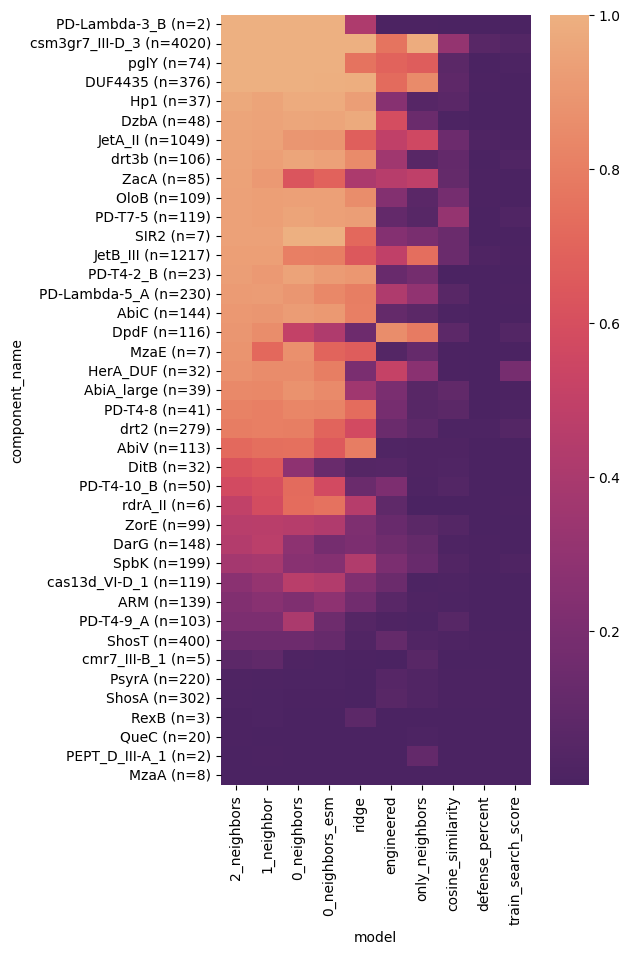

In [31]:
plt.subplots(figsize=(5, 10))
sns.heatmap(wide_gene_ap_df, cmap='flare_r')

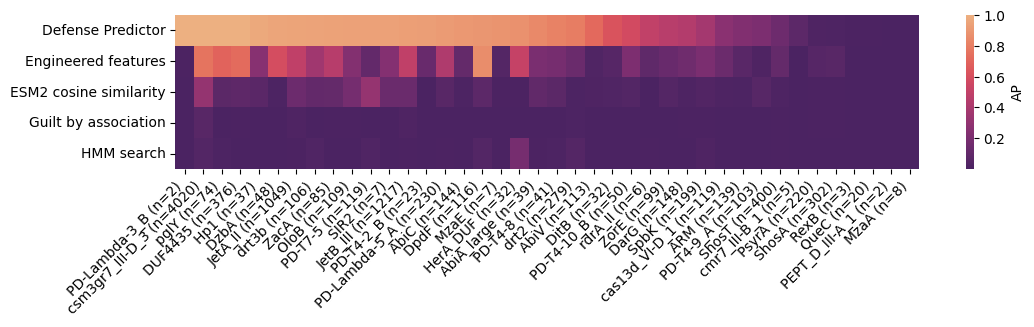

In [32]:
plt.subplots(figsize=(12, 2))
sns.heatmap(wide_gene_ap_df[['2_neighbors', 'engineered', 'cosine_similarity', 
                             'defense_frac_n_log_p', 'train_search_score']].rename(columns=model_name_map).T, cmap='flare_r', 
            cbar_kws={'label': 'AP'})
plt.xticks(ha='right', rotation=45)
plt.xlabel('')
plt.ylabel('')
plt.savefig('../figures/per_gene_cluster_ap.png', bbox_inches='tight', dpi=300)

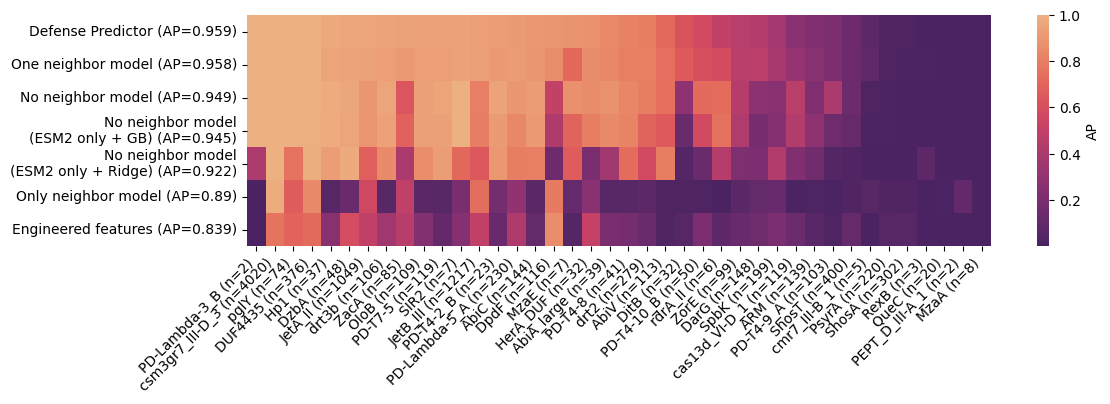

In [42]:
plt.subplots(figsize=(12, 3))
sns.heatmap(wide_gene_ap_df[['2_neighbors', '1_neighbor', '0_neighbors',
                     '0_neighbors_esm', 
                     'ridge', 'only_neighbors', 'engineered']].rename(columns=ap_name_map).T, cmap='flare_r', 
            cbar_kws={'label': 'AP'})
plt.xticks(ha='right', rotation=45)
plt.xlabel('')
plt.ylabel('')
plt.savefig('../figures/per_gene_cluster_ap_abalations.png', bbox_inches='tight', dpi=300)

In [33]:
(wide_gene_ap_df['2_neighbors'] > 0.5).sum()

25

In [34]:
len(wide_gene_ap_df)

40

In [36]:
(merged_prediction_df[~merged_prediction_df['defense']]
 .groupby('go_process')
 .agg(max_p=('2_neighbors', 'max'), 
      count=('seq_id', 'count'), 
      avg_p=('2_neighbors', 'mean'), 
      sum_p=('2_neighbors', 'sum'))
 .reset_index()
 .sort_values('sum_p', ascending=False)
 .head(50))

,go_process,max_p,count,avg_p,sum_p
1091,signal transduction,0.999710,2730,0.006721,18.348958
45,DNA methylation on adenine,0.998918,107,0.168285,18.006498
55,DNA repair,0.999339,1002,0.010831,10.852227
921,proteolysis,1.000000,6050,0.001481,8.961941
62,DNA replication,0.999998,1967,0.004528,8.907127
1021,regulation of transcription%2C DNA-templated,0.999992,7763,0.000826,6.410557
981,regulation of DNA-templated transcription,1.000000,7731,0.000804,6.214410
888,protein phosphorylation,0.999902,1893,0.002856,5.405804
705,nucleobase-containing compound metabolic process,0.999558,136,0.032265,4.387980
373,chromosome segregation | chromosome condensation,0.999996,103,0.039361,4.054201


In [37]:
pd.set_option('display.max_colwidth', 100)

In [38]:
(merged_prediction_df[merged_prediction_df['go_process'] == 'signal transduction']
 .groupby('name')
 .agg(max_p=('2_neighbors', 'max'), 
      count=('seq_id', 'count'), 
      avg_p=('2_neighbors', 'mean'), 
      sum_p=('2_neighbors', 'sum'))
 .reset_index()
 .sort_values('max_p', ascending=False))

,name,max_p,count,avg_p,sum_p
19,toll/interleukin-1 receptor domain-containing protein,9.999516e-01,19,2.693315e-01,5.117299e+00
9,TIR domain-containing protein,9.997416e-01,247,1.020240e-01,2.519994e+01
3,HAMP domain-containing protein,3.025340e-05,197,2.868097e-07,5.650150e-05
17,methyl-accepting chemotaxis protein,5.391546e-06,1923,5.078503e-08,9.765962e-05
15,histidine kinase dimerization/phospho-acceptor domain-containing protein,4.924399e-06,45,2.448328e-07,1.101747e-05
2,HAMP domain-containing methyl-accepting chemotaxis protein,2.275172e-06,31,1.198246e-07,3.714562e-06
5,MtrAB system histidine kinase MtrB,1.169721e-06,56,4.591307e-08,2.571132e-06
12,chemotaxis protein CheW,8.822609e-07,123,1.681339e-08,2.068047e-06
18,sensor histidine kinase,6.208688e-07,7,9.196026e-08,6.437218e-07
1,ArsS family sensor histidine kinase,4.506921e-07,18,1.210496e-07,2.178893e-06


In [39]:
tir_proteins = merged_prediction_df[merged_prediction_df['name'].isin(['toll/interleukin-1 receptor domain-containing protein', 
                                                                       'TIR domain-containing protein'])]

In [40]:
tir_proteins

,defense,2_neighbors,1_neighbor,0_neighbors,ridge,0_neighbors_esm,only_neighbors,engineered,train_search_score,cosine_similarity,defense_percent,seq_id,protein_id,protein_context_id,gene_name,name,go_process,cog_name
1326,False,1.928274e-05,1.723351e-05,0.000172,0.018408,3.340153e-05,0.014401,4.378583e-03,31.1,0.979501,0.0,00ad065bda41de6126a38b136bee5b64df894b4a7787fecc54fce7a7,WP_230266804.1,WP_230266804.1|NZ_JAHDSX010000004.1|83|-,,TIR domain-containing protein,signal transduction,None
2279,False,2.470236e-08,3.280677e-08,0.000007,0.018864,3.377364e-06,0.000430,6.987544e-07,36.6,0.970734,0.0,01425250baf05ecb8c8fc554eaf370b8452f754a6a5eb5d517563c37,WP_265529893.1,WP_265529893.1|NZ_JANPVQ010000001.1|1430307|+,,TIR domain-containing protein,signal transduction,None
2280,False,5.803077e-08,4.102617e-08,0.000002,0.004222,1.988273e-07,0.000992,1.665541e-07,39.2,0.970957,0.0,83f62a7cb18f983ead2577509f606592d0c85c5caf9ed828719b8c16,WP_260484136.1,WP_260484136.1|NZ_CP102630.1|912480|+,,TIR domain-containing protein,signal transduction,None
2657,False,1.486972e-04,6.590277e-05,0.000340,0.069689,1.801148e-04,0.015495,3.195732e-03,20.5,0.983954,0.0,016c91d54c86fd09f5560a582af68a295a06bf0fccfe59afa11b421d,WP_261564635.1,WP_261564635.1|NZ_JANEZS010000002.1|31831|-,,TIR domain-containing protein,signal transduction,None
2658,False,1.835912e-04,5.305607e-05,0.000220,0.202414,3.697019e-05,0.046666,1.426108e-02,14.9,0.976491,0.0,1350f627752fab226cbc47b55bb8aa4bbff43c92b5701215165fa69e,WP_011606591.1,WP_011606591.1|NC_008278.1|5953699|+,,TIR domain-containing protein,signal transduction,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176197,True,4.546451e-01,6.856084e-01,0.234381,0.397252,1.702864e-01,0.209152,1.920554e-01,44.7,0.986814,0.0,1fe49f0a5885ccc7d1c9947f9bffc28474faaf82e035dd010fe31611,WP_004222634.1,WP_004222634.1|NZ_CP022413.2|1201588|+,SpbK__SpbK,toll/interleukin-1 receptor domain-containing protein,None,None
176232,True,9.997416e-01,9.997529e-01,0.995877,0.872696,9.978343e-01,0.851651,4.938315e-03,29.5,0.982476,0.0,23be82cd898a1b80f59e116e86529ffaa3876988a8ffbc5a81f4c5ab,WP_071612266.1,WP_071612266.1|NZ_CP015756.1|1688787|+,SpbK__SpbK,TIR domain-containing protein,signal transduction,None
176286,True,7.167944e-05,2.220858e-04,0.000338,0.755708,8.362582e-05,0.058328,2.591095e-01,26.3,0.984197,0.0,4fe0284e8a903b9c30690ba94fc55b0a860cbdf0fd72528bb22e7f91,WP_177189876.1,WP_177189876.1|NZ_FOHS01000004.1|350548|+,SpbK__SpbK,toll/interleukin-1 receptor domain-containing protein,None,None
176310,True,8.795148e-01,9.251603e-01,0.803410,0.961949,3.989746e-01,0.142779,9.576374e-01,37.2,0.977813,1.0,e87d6e917c1da422e63be1ecc34174573b20ab15ee2b57eb0282d96c,WP_075035257.1,WP_075035257.1|NZ_FOSB01000002.1|139421|-,SpbK__SpbK,toll/interleukin-1 receptor domain-containing protein,None,None


In [41]:
merged_prediction_df.to_csv('../data/interim/all_annotated_test_predictions.csv', index=False)

In [ ]:
out_df = (prediction_df[['2_neighbors']]
          .reset_index()
          .rename(columns={'2_neighbors': 'beaker_prediction'}))

In [ ]:
out_df.to_csv('../data/interim/test_predictions_beaker.csv', index=False)